In [1]:
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import cv2

from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# http://ac.els-cdn.com/S0167865502003835/1-s2.0-S0167865502003835-main.pdf?_tid=d5fda8d6-a475-11e6-8542-00000aab0f6b&acdnat=1478473849_ce42c7d93d2c665f410c24539c1fafdf
def to_YUV(img):
    image = Image.fromarray(img)
    ycbcr = image.convert('YCbCr')
    return np.ndarray((image.size[1], image.size[0], 3), 'u1', ycbcr.tobytes())
    # TODO: subsample U and V to be N/2 x N/2

In [4]:
d = fetch_lfw_people(color=True, min_faces_per_person=70)
imgs = d.images.astype(np.uint8)
bw = rgb2gray(imgs)
y = d.target

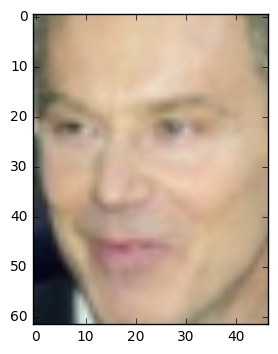

In [5]:
plt.imshow(imgs[1])

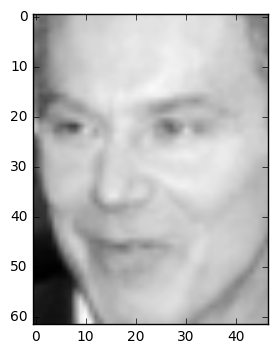

In [6]:
plt.imshow(bw[1], cmap=plt.get_cmap('gray'))

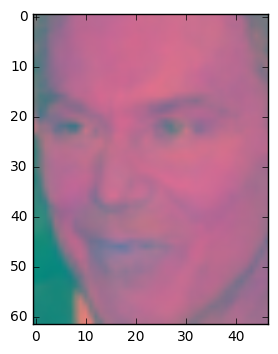

In [7]:
yuv1 = to_YUV(imgs[1])
plt.imshow(yuv1)

# OpenCV

In [8]:
train, test = list(KFold(n_splits=2, shuffle=True).split(bw))[0]

In [9]:
model = cv2.face.createEigenFaceRecognizer()
model.train(bw[train], d.target[train])

In [10]:
wrong = []
for i in test:
    pred = model.predict(bw[i])
    if pred != y[i]:
        wrong.append((pred, y[i]))
len(wrong)/len(test)

0.4704968944099379

In [11]:
vectors = model.getEigenVectors().T.reshape(model.getEigenVectors().shape[-1], 62, 47)

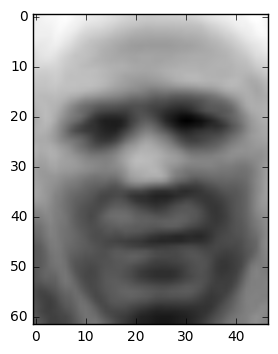

In [12]:
plt.imshow(vectors[3], cmap=plt.get_cmap('gray'))

# Manual

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    bw.reshape(bw.shape[0], bw.shape[1] * bw.shape[2]), d.target, test_size=0.25, random_state=42)


In [14]:
n_components = 150
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

In [15]:
# eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [16]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

In [17]:
clf = clf.fit(X_train_pca, y_train)
print(clf.best_estimator_)

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [18]:
y_pred = clf.predict(X_test_pca)

In [19]:
print(classification_report(y_test, y_pred, target_names=d.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.90      0.69      0.78        13
     Colin Powell       0.78      0.85      0.82        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.84      0.95      0.89       146
Gerhard Schroeder       1.00      0.80      0.89        25
      Hugo Chavez       1.00      0.73      0.85        15
       Tony Blair       0.94      0.83      0.88        36

      avg / total       0.86      0.86      0.86       322



# Color - work in progress
http://ac.els-cdn.com/S0167865502003835/1-s2.0-S0167865502003835-main.pdf?_tid=d5fda8d6-a475-11e6-8542-00000aab0f6b&acdnat=1478473849_ce42c7d93d2c665f410c24539c1fafdf


In [20]:
rgb2yuv = np.array([[0.299, 0.587, 0.114],
                    [-0.14713, -0.28886, 0.436],
                    [0.615, -0.51499, -0.10001]])
yuv = np.dot(imgs, rgb2yuv.T)

In [21]:
X_train_all, X_test_all, y_train, y_test = train_test_split(
    yuv, d.target, test_size=0.25, random_state=42)

In [22]:
def subsample(X):
    Y = X[:, :, :, 0]
    U = X[:, ::2, ::2, 1]
    V = X[:, ::2, ::2, 2]
    return (Y, U, V)

X_train = subsample(X_train_all)
X_test = subsample(X_test_all)

In [23]:
X_train[0].shape

(966, 62, 47)

In [24]:
n_components = 150
X_train_pca = []
X_test_pca = []

for i in range(3):
    X = X_train[i]
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    Xt = X_test[i]
    Xt = Xt.reshape(Xt.shape[0], Xt.shape[1] * Xt.shape[2])
    pca = PCA(n_components=n_components, svd_solver='randomized',
      whiten=True).fit(X)
    X_train_pca.append(pca.transform(X))
    X_test_pca.append(pca.transform(Xt))